In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

path = '/content/drive/MyDrive/molecule_classification_dataset.csv'

df = pd.read_csv(path)

df.head()

,Unnamed: 0,ChEMBL ID,Name,SMILES,Molecular Weight,LogP,HBA,HBD,TPSA,Protein
0,0,CHEMBL292323,NaN,COc1cccc2c(C(=O)Nc3ccccc3)c(SSc3c(C(=O)Nc4cccc...,622.77,7.99,8.0,2.0,86.52,EGFR
1,1,CHEMBL304414,NaN,Cn1c(SSc2c(C(=O)Nc3ccccc3)c3ccccc3n2C)c(C(=O)N...,562.72,7.97,6.0,2.0,68.06,EGFR
2,2,CHEMBL62176,NaN,CN1C(=S)C(C(=O)Nc2ccccc2)c2ccccc21,282.37,3.19,2.0,1.0,32.34,EGFR
3,3,CHEMBL62701,NaN,Cn1c(SSc2c(C(=O)Nc3ccccc3)c3cccnc3n2C)c(C(=O)N...,564.70,6.76,8.0,2.0,93.84,EGFR
4,4,CHEMBL137617,NaN,C/N=N/Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,357.22,4.54,5.0,2.0,74.56,EGFR


In [5]:
df.info()

df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8711 entries, 0 to 8710
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        8711 non-null   int64  
 1   ChEMBL ID         8711 non-null   object 
 2   Name              263 non-null    object 
 3   SMILES            8711 non-null   object 
 4   Molecular Weight  8711 non-null   float64
 5   LogP              8655 non-null   float64
 6   HBA               8655 non-null   float64
 7   HBD               8655 non-null   float64
 8   TPSA              8655 non-null   float64
 9   Protein           8711 non-null   object 
dtypes: float64(5), int64(1), object(4)
memory usage: 680.7+ KB


Index(['Unnamed: 0', 'ChEMBL ID', 'Name', 'SMILES', 'Molecular Weight', 'LogP',
       'HBA', 'HBD', 'TPSA', 'Protein'],
      dtype='object')

Filter Dataset by Target

In [6]:
df_egfr = df[['ChEMBL ID', 'SMILES', 'Molecular Weight', 'LogP', 'HBA', 'HBD', 'TPSA']].dropna()

df_egfr.rename(columns={'ChEMBL ID': 'compound_id'}, inplace=True)

df_egfr.head()


,compound_id,SMILES,Molecular Weight,LogP,HBA,HBD,TPSA
0,CHEMBL292323,COc1cccc2c(C(=O)Nc3ccccc3)c(SSc3c(C(=O)Nc4cccc...,622.77,7.99,8.0,2.0,86.52
1,CHEMBL304414,Cn1c(SSc2c(C(=O)Nc3ccccc3)c3ccccc3n2C)c(C(=O)N...,562.72,7.97,6.0,2.0,68.06
2,CHEMBL62176,CN1C(=S)C(C(=O)Nc2ccccc2)c2ccccc21,282.37,3.19,2.0,1.0,32.34
3,CHEMBL62701,Cn1c(SSc2c(C(=O)Nc3ccccc3)c3cccnc3n2C)c(C(=O)N...,564.70,6.76,8.0,2.0,93.84
4,CHEMBL137617,C/N=N/Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,357.22,4.54,5.0,2.0,74.56


Novelty – Tokenize SMILES

In [7]:
def build_vocabulary(smiles_list):
    charset = set()
    for smi in smiles_list:
        for char in smi:
            charset.add(char)
    return sorted(list(charset))

smiles_list = df_egfr['SMILES'].tolist()
vocab = build_vocabulary(smiles_list)

char_to_index = {char: idx + 1 for idx, char in enumerate(vocab)}  # +1 to reserve 0 for padding
index_to_char = {idx: char for char, idx in char_to_index.items()}

print(f"Vocabulary size: {len(char_to_index)}")
print(f"Characters: {list(char_to_index.keys())}")


Vocabulary size: 35
Characters: ['#', '(', ')', '+', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '=', '@', 'B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S', '[', '\\', ']', 'a', 'c', 'l', 'n', 'o', 'r', 's']


In [8]:
def tokenize_smiles(smiles, mapping, max_len=100):
    tokens = [mapping.get(char, 0) for char in smiles]
    if len(tokens) > max_len:
        tokens = tokens[:max_len]
    else:
        tokens += [0] * (max_len - len(tokens))
    return tokens

MAX_LEN = 100
df_egfr['tokenized'] = df_egfr['SMILES'].apply(lambda x: tokenize_smiles(x, char_to_index, MAX_LEN))

df_egfr[['SMILES', 'tokenized']].head()


,SMILES,tokenized
0,COc1cccc2c(C(=O)Nc3ccccc3)c(SSc3c(C(=O)Nc4cccc...,"[18, 23, 30, 8, 30, 30, 30, 30, 9, 30, 2, 18, ..."
1,Cn1c(SSc2c(C(=O)Nc3ccccc3)c3ccccc3n2C)c(C(=O)N...,"[18, 32, 8, 30, 2, 25, 25, 30, 9, 30, 2, 18, 2..."
2,CN1C(=S)C(C(=O)Nc2ccccc2)c2ccccc21,"[18, 22, 8, 18, 2, 15, 25, 3, 18, 2, 18, 2, 15..."
3,Cn1c(SSc2c(C(=O)Nc3ccccc3)c3cccnc3n2C)c(C(=O)N...,"[18, 32, 8, 30, 2, 25, 25, 30, 9, 30, 2, 18, 2..."
4,C/N=N/Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1,"[18, 7, 22, 15, 22, 7, 22, 30, 8, 30, 30, 30, ..."


Create Bioactivity Labels

In [9]:
df_egfr['bioactivity_class'] = df_egfr['Molecular Weight'].apply(lambda x: 1 if x < 500 else 0)

df_egfr['bioactivity_class'].value_counts()


,count
bioactivity_class,
1,6458
0,2197


Prepare Features and Labels

In [10]:
import numpy as np

X = np.array(df_egfr['tokenized'].tolist())
y = df_egfr['bioactivity_class'].values

print("Feature shape:", X.shape)
print("Label shape:", y.shape)


Feature shape: (8655, 100)
Label shape: (8655,)


Build & Train the Deep Learning Model

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (6924, 100)
Test size: (1731, 100)


 1D CNN Model

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

vocab_size = len(char_to_index) + 1
embedding_dim = 64
max_len = 100

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, max_len))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 64)        │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,713 (202.00 KB)

 Trainable params: 51,713 (202.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [16]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7980 - loss: 0.4717 - val_accuracy: 0.8932 - val_loss: 0.2782
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8841 - loss: 0.2788 - val_accuracy: 0.9076 - val_loss: 0.2362
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9103 - loss: 0.2356 - val_accuracy: 0.9235 - val_loss: 0.1968
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9183 - loss: 0.2183 - val_accuracy: 0.9264 - val_loss: 0.2010
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9227 - loss: 0.1932 - val_accuracy: 0.9351 - val_loss: 0.1714
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9301 - loss: 0.1767 - val_accuracy: 0.9380 - val_loss: 0.1744
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9236 - loss: 0.1866 - val_accuracy: 0.9134 - val_loss: 0.2281
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9340 - loss: 0.1713 - val_acc

Model Evaluation and Visualization

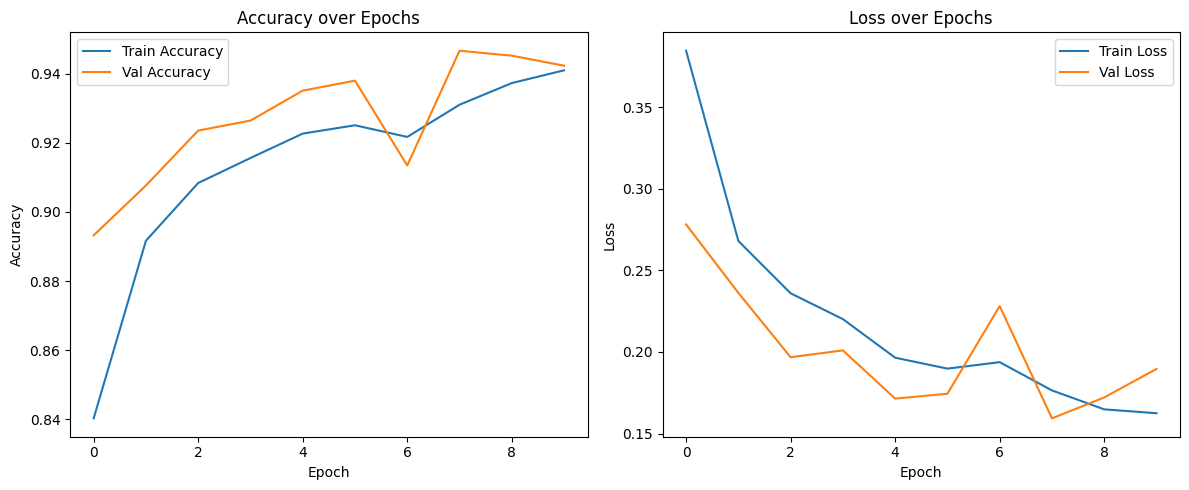

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


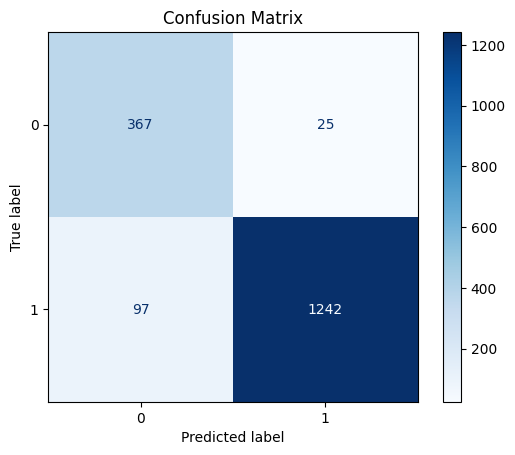

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


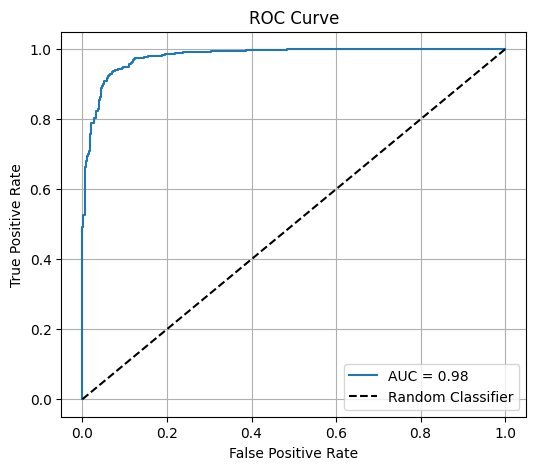

In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

New Prediction

In [25]:
def predict_smiles(smiles):
    tokens = [char_to_index.get(c, 0) for c in smiles]
    tokens = tokens[:100] + [0]*(100 - len(tokens)) if len(tokens) < 100 else tokens[:100]
    tokens = np.array(tokens).reshape(1, -1)
    prob = model.predict(tokens)[0][0]
    return "Active" if prob > 0.5 else "Inactive", prob


In [26]:
predict_smiles("CCO")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


('Active', np.float32(0.98260385))